<a href="https://colab.research.google.com/github/MayBornWitIt/Income_-Prediction_Analysis/blob/main/Income_Machine_Learning_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [1]:
## Pandas
import pandas as pd
## Numpy
import numpy as np
## MatPlotLib
import matplotlib.pyplot as plt
## Seaborn
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, \
classification_report
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


## Set global scikit-learn configuration
from sklearn import set_config

## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

from IPython.core.display import clear_output

import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

# **Functions**

In [2]:

## Define a function that takes in arguments and prints out a classification report and confusion matrix
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            cmap='Greens', normalize=None, classes=None,
                            figsize=(20,5), name='Classification Model',
                            average='binary', zero_division=0):
  """Takes as required arguments: a model, traing features, training labels,
  testing feature, testing labels
  Prints a classification reports and confusion matrics for each data set
  returns a dataframe of metrics

  Optional arguments:
    cmap: colormap
    normalize: confusion matrix normalization ['true', 'pred', 'all' or None]
    classes: ordered list of class labels
    figsize: size of figure
    name: give your model a name
    average: how to aggregate scores for multiclass problems
    zero_division: what should the result of divide by zero be?"""

  # Gather model predictions
  train_preds = model.predict(X_train)
  test_preds = model.predict(X_test)

  # Display classification report and confusion matrices
  print('======Train Set Metrics======')
  print(metrics.classification_report(y_train, train_preds,
                                      zero_division=0,
                                      target_names=classes))

  print('======Test Set Metrics======')
  print(metrics.classification_report(y_test, test_preds,
                                      zero_division=0,
                                      target_names=classes))

  fig, axes = plt.subplots(ncols=2, figsize=figsize)

  ConfusionMatrixDisplay.from_predictions(y_train, train_preds, cmap=cmap,
                                display_labels=classes,
                                normalize=normalize, ax=axes[0])
  axes[0].set_title('Train Confusion Matrix')

  ConfusionMatrixDisplay.from_predictions(y_test, test_preds, cmap=cmap,
                              display_labels=classes,
                              normalize=normalize, ax=axes[1])
  axes[1].set_title('Test Confusion Matrix')
  plt.show()

  # If there are more than 2 classes and an average has not been set,
  # set average to 'macro'
  if average == 'binary' and y_train.nunique() > 2:
    average = 'macro'

  # Create a dataframe of scores to return
  scores = pd.DataFrame()

  # Training

  scores.loc[name, 'Train Accuracy'] = accuracy_score(y_train, train_preds)
  scores.loc[name, 'Train Recall'] = recall_score(y_train, train_preds,
                                                           average=average,
                                                       zero_division=zero_division)
  scores.loc[name, 'Train Precision'] = precision_score(y_train, train_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Train F1-Score'] = f1_score(y_train, train_preds,
                                                           average=average,
                                                     zero_division=zero_division)

  # Testing
  scores.loc[name, 'Test Accuracy'] = accuracy_score(y_test, test_preds)
  scores.loc[name, 'Test Recall'] = recall_score(y_test, test_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Test Precision'] = precision_score(y_test, test_preds,
                                                           average=average,
                                                      zero_division=zero_division)
  scores.loc[name, 'Test F1-Score'] = f1_score(y_test, test_preds,
                                                           average=average,
                                                     zero_division=zero_division)

  return scores

# **Load the Data**

Data Source: https://www.kaggle.com/datasets/wenruliu/adult-income-dataset

In [3]:
#Load the Data
df = pd.read_csv('/content/drive/MyDrive/adult.csv.zip')

backup_df = df.copy()

# **Explore the Data**

In [4]:
# Display the first (8) rows of the dataframe
df.head(8)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K


In [5]:
# Display the number of rows and columns for the dataframe
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 48842 rows, and 15 columns.
The rows represent 48842 observations, and the columns represent 14 features and 1 target variable.


In [6]:
# Display the column names, count of non-null values, and their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [7]:
#Display the unique values in each column
df.nunique()

age                   74
workclass              9
fnlwgt             28523
education             16
educational-num       16
marital-status         7
occupation            15
relationship           6
race                   5
gender                 2
capital-gain         123
capital-loss          99
hours-per-week        96
native-country        42
income                 2
dtype: int64

In [8]:
## Display the descriptive statistics for the numeric columns
df.describe(include="number")

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


Based on the numeric statistical data above, there are noticeable outliers in some of the columns. "Hours-per-week" column displays max hours as 99 and average being 40. Maximum age being 90 and with average being 38 years of age. The one that really stands out capital-gain feature with a max at 99999 when the average is 1079. Outliers definitely need addressing.

In [9]:
## Display the descriptive statistics for the non-numeric columns
df.describe(include="object")

,workclass,education,marital-status,occupation,relationship,race,gender,native-country,income
count,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,37155


In [10]:
# Display the number of duplicate rows in the dataset
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 52 duplicate rows.


In [11]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)

In [12]:
# Confirm now duplicate rows remain
df.duplicated().sum()

0

In [13]:
# Display the total number of missing values
print(f'There are {df.isna().sum().sum()} missing values.')

There are 0 missing values.


In [14]:
# Drop null values and display new dataset shape
df.dropna().shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')

There are 48790 rows, and 15 columns.


In [15]:
# Check values of categorical columns
cat_cols = list(df.select_dtypes(include = 'object'))
for col in cat_cols:
    print(col)
    print(df[col].value_counts(dropna = False))
    print()

workclass
Private             33860
Self-emp-not-inc     3861
Local-gov            3136
?                    2795
State-gov            1981
Self-emp-inc         1694
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

education
HS-grad         15770
Some-college    10863
Bachelors        8013
Masters          2656
Assoc-voc        2060
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           954
Prof-school       834
9th               756
12th              655
Doctorate         594
5th-6th           507
1st-4th           245
Preschool          81
Name: education, dtype: int64

marital-status
Married-civ-spouse       22366
Never-married            16082
Divorced                  6630
Separated                 1530
Widowed                   1518
Married-spouse-absent      627
Married-AF-spouse           37
Name: marital-status, dtype: int64

occupation
Prof-specialty       6165
Craft-repair         6102
E

After reviewing each feature's categories there are a few that can use some engineering prior to machine learning.

In [16]:
# Drop irrelevant and redundant features
df = df.drop(['fnlwgt', 'educational-num','relationship','capital-gain','capital-loss'], axis=1)
df.head()

,age,workclass,education,marital-status,occupation,race,gender,hours-per-week,native-country,income
0,25,Private,11th,Never-married,Machine-op-inspct,Black,Male,40,United-States,<=50K
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,White,Male,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,White,Male,40,United-States,>50K
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Black,Male,40,United-States,>50K
4,18,?,Some-college,Never-married,?,White,Female,30,United-States,<=50K


## **Feature Engineering**

In [17]:
# Merge categories 'Local-gov', 'State-gov', & 'Federal-gov' into one
# category labeled 'Government'
df['workclass'] = df['workclass'].replace({'Local-gov': 'Government','State-gov': 'Government','Federal-gov': 'Government'})

In [18]:
# Remove categories 'Without-pay', 'Never-worked' from 'workclass'
# column since frequency is relatively low
df = df[df.workclass  != 'Never-worked']
df = df[df.workclass != 'Without-pay']

In [19]:
df['workclass'].value_counts()

Private             33860
Government           6549
Self-emp-not-inc     3861
?                    2795
Self-emp-inc         1694
Name: workclass, dtype: int64

In [20]:
# Remove categories 'Armed-Forces' & 'Priv-house-serv' from 'occupation'
# column since frequency is relatively low
df = df[df.occupation  != 'Armed-Forces']
df = df[df.occupation  != 'Priv-house-serv']

In [21]:
df['occupation'].value_counts()

Prof-specialty       6165
Craft-repair         6101
Exec-managerial      6081
Adm-clerical         5603
Sales                5500
Other-service        4917
Machine-op-inspct    3015
?                    2795
Transport-moving     2354
Handlers-cleaners    2069
Farming-fishing      1477
Tech-support         1445
Protective-serv       982
Name: occupation, dtype: int64

In [22]:
# Remove categories 'Preschool' & '1st-4th' from 'education'
# column since frequency is relatively low
df = df[df.education  != '1st-4th']
df = df[df.education  != 'Preschool']

In [23]:
df['education'].value_counts()

HS-grad         15658
Some-college    10828
Bachelors        8000
Masters          2653
Assoc-voc        2054
11th             1791
Assoc-acdm       1596
10th             1379
7th-8th           934
Prof-school       833
9th               740
12th              646
Doctorate         593
5th-6th           487
Name: education, dtype: int64

In [24]:
# Rename category labels
df.rename({'marital-status': 'marital_status'}, axis=1, inplace=True)

In [25]:
# Remove category 'Married-AF-spouse' from 'marital_status'
# column since frequency is relatively low
df = df[df.marital_status  != 'Married-AF-spouse']

In [26]:
df['marital_status'].value_counts()

Married-civ-spouse       22164
Never-married            15883
Divorced                  6566
Separated                 1496
Widowed                   1451
Married-spouse-absent      595
Name: marital_status, dtype: int64

In [27]:
special_chars = '[?]'
rows_with_special_chars = df['workclass'].str.contains(special_chars)

# drop rows with special characters
df = df[~rows_with_special_chars]

In [28]:
df['workclass'].value_counts()

Private             33348
Government           6516
Self-emp-not-inc     3837
Self-emp-inc         1692
Name: workclass, dtype: int64

In [29]:
spec_chars = '[?]'
rows_with_spec_chars = df['occupation'].str.contains(spec_chars)

# drop rows with special characters
df = df[~rows_with_spec_chars]

In [30]:
df['occupation'].value_counts()

Prof-specialty       6156
Exec-managerial      6071
Craft-repair         6063
Adm-clerical         5588
Sales                5485
Other-service        4835
Machine-op-inspct    2966
Transport-moving     2339
Handlers-cleaners    2037
Tech-support         1445
Farming-fishing      1428
Protective-serv       980
Name: occupation, dtype: int64

In [31]:
df = df.rename(columns={'native-country':'continent'})

In [32]:
special_chars = '[?]'
rows_with_special_chars = df['continent'].str.contains(special_chars)

# drop rows with special characters
df = df[~rows_with_special_chars]

In [33]:
# Re-categorize each country to there appropriate continent in order to reduce categories
df['continent'] = df['continent'].replace("United-States","N_America")
df['continent'] = df['continent'].replace("Outlying-US(Guam-USVI-etc)","N_America")
df['continent'] = df['continent'].replace("Mexico","N_America")
df['continent'] = df['continent'].replace("Canada","N_America")
df['continent'] = df['continent'].replace("Puerto-Rico","N_America")

df['continent'] = df['continent'].replace("Philippines","Asia")
df['continent'] = df['continent'].replace("India","Asia")
df['continent'] = df['continent'].replace("Laos","Asia")
df['continent'] = df['continent'].replace("China","Asia")
df['continent'] = df['continent'].replace("Japan","Asia")
df['continent'] = df['continent'].replace("Vietnam","Asia")
df['continent'] = df['continent'].replace("Taiwan","Asia")
df['continent'] = df['continent'].replace("Iran","Asia")
df['continent'] = df['continent'].replace("Greece","Asia")
df['continent'] = df['continent'].replace("Cambodia","Asia")
df['continent'] = df['continent'].replace("Hong","Asia")
df['continent'] = df['continent'].replace("Thailand","Asia")

df['continent'] = df['continent'].replace("El-Salvador","C_America")
df['continent'] = df['continent'].replace("Guatemala","C_America")
df['continent'] = df['continent'].replace("Honduras","C_America")

df['continent'] = df['continent'].replace("Nicaragua","S_America")
df['continent'] = df['continent'].replace("Columbia","S_America")
df['continent'] = df['continent'].replace("Peru","S_America")
df['continent'] = df['continent'].replace("Ecuador","S_America")

df['continent'] = df['continent'].replace("Yugoslavia","Europe")
df['continent'] = df['continent'].replace("Germany","Europe")
df['continent'] = df['continent'].replace("England","Europe")
df['continent'] = df['continent'].replace("Portugal","Europe")
df['continent'] = df['continent'].replace("France","Europe")
df['continent'] = df['continent'].replace("Ireland","Europe")
df['continent'] = df['continent'].replace("Italy","Europe")
df['continent'] = df['continent'].replace("Scotland","Europe")
df['continent'] = df['continent'].replace("Hungary","Europe")
df['continent'] = df['continent'].replace("Poland","Europe")
df['continent'] = df['continent'].replace("Holand-Netherlands","Europe")

df['continent'] = df['continent'].replace("Cuba","Caribbean")
df['continent'] = df['continent'].replace("Dominican-Republic","Caribbean")
df['continent'] = df['continent'].replace("Trinadad&Tobago","Caribbean")
df['continent'] = df['continent'].replace("Jamaica","Caribbean")
df['continent'] = df['continent'].replace("Haiti","Caribbean")

df['continent'].value_counts()

N_America    42072
Asia           957
Europe         665
Caribbean      400
S_America      206
C_America      201
South          101
Name: continent, dtype: int64

In [34]:
# Review all changes
df.head()

,age,workclass,education,marital_status,occupation,race,gender,hours-per-week,continent,income
0,25,Private,11th,Never-married,Machine-op-inspct,Black,Male,40,N_America,<=50K
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,White,Male,50,N_America,<=50K
2,28,Government,Assoc-acdm,Married-civ-spouse,Protective-serv,White,Male,40,N_America,>50K
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Black,Male,40,N_America,>50K
5,34,Private,10th,Never-married,Other-service,White,Male,30,N_America,<=50K


## **Exploratory Data Analysis (EDA)**

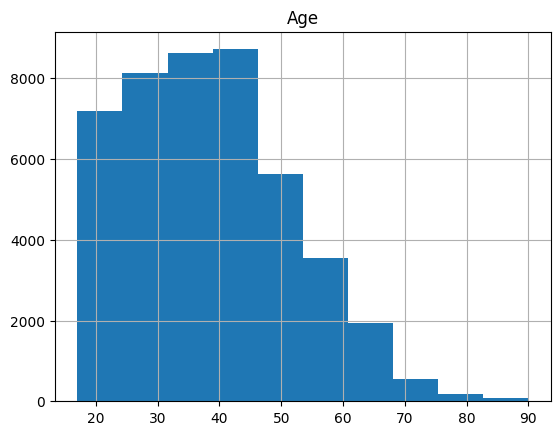

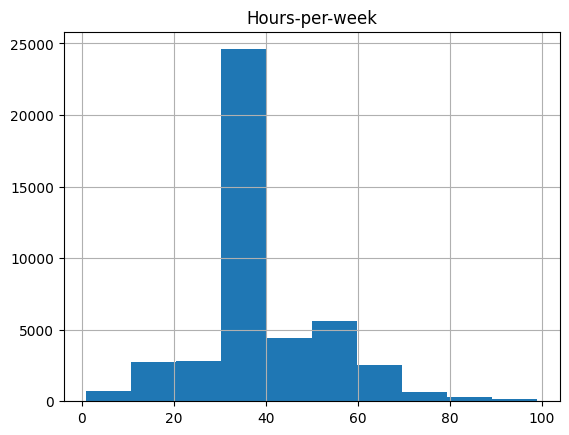

In [35]:
for col in df.select_dtypes('number'):
    df[col].hist()
    plt.title(col.capitalize())

    plt.show()

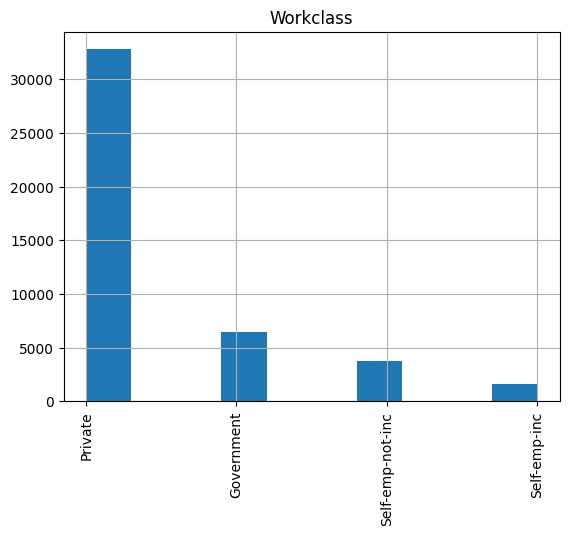

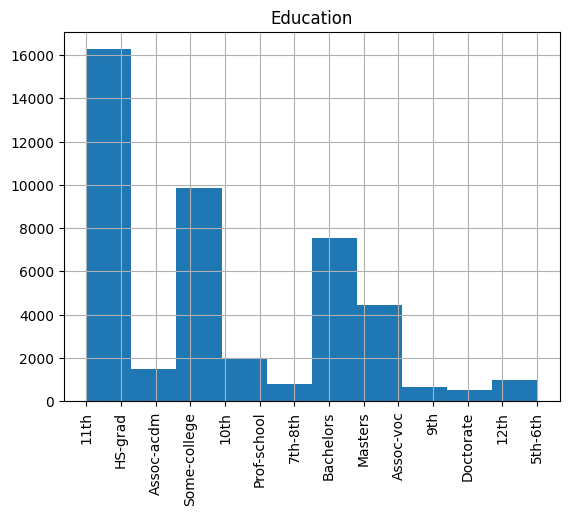

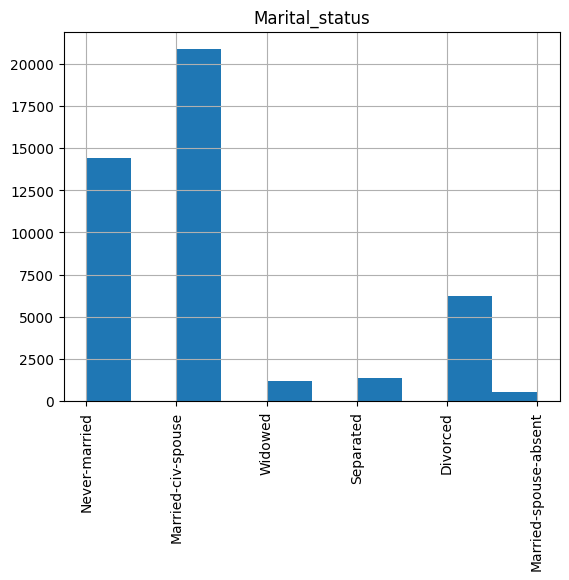

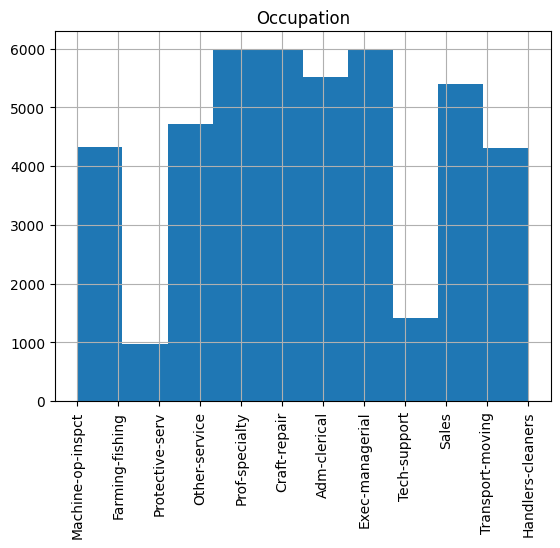

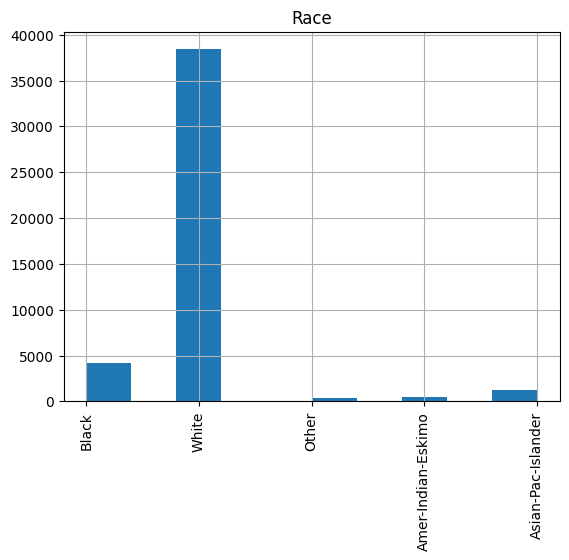

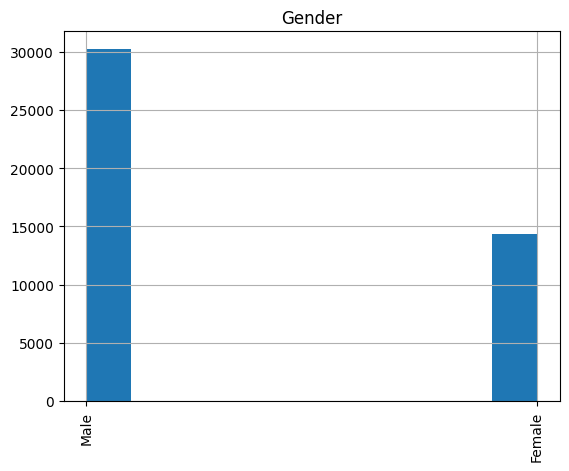

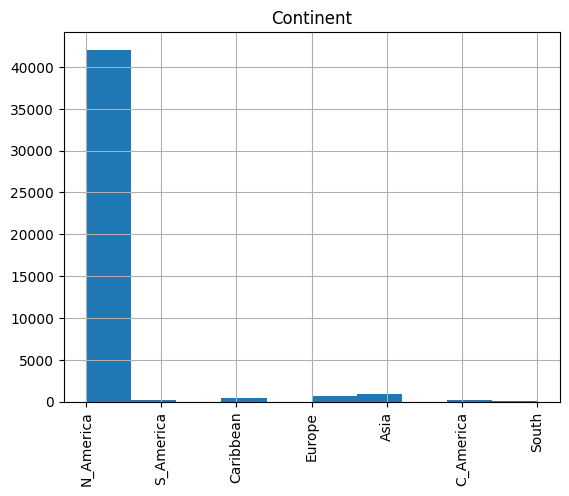

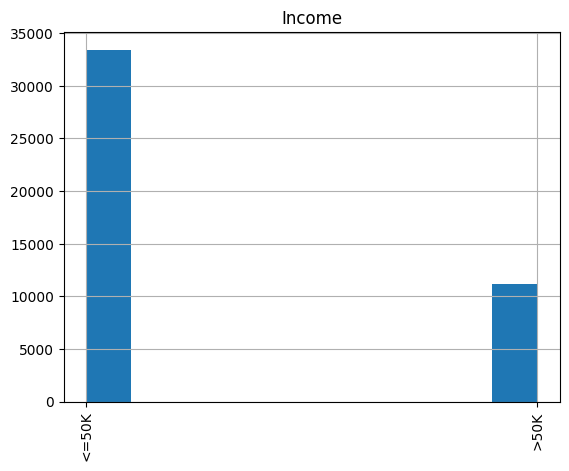

In [36]:
for col in df.select_dtypes('object'):
    df[col].hist()
    plt.title(col.capitalize())
    plt.xticks(rotation=90)
    plt.show()

In [37]:
# Interactive Univariate Visual in the form of a Boxplot for "age" feature
fig = px.box(df, y='age')

fig.show()

Based on the boxplot above, it is displayed to have outliers beyond 75 years of age. Median being 37 years of age.

### **Handle Outliers**

In [38]:
# Defining sections of the dataset to help identify and refine outliers
def find_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   return outliers

In [39]:
# Considering their were outliers in multiple features we will refine 3 features
outliers = find_outliers_IQR(df[['age','education', 'hours-per-week']])

outliers

,age,education,hours-per-week
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
5,NaN,NaN,30.0
...,...,...,...
48837,NaN,NaN,NaN
48838,NaN,NaN,NaN
48839,NaN,NaN,NaN
48840,NaN,NaN,20.0


In [40]:
# Drop defined outliers
def drop_outliers_IQR(df):

   q1=df.quantile(0.25)

   q3=df.quantile(0.75)

   IQR=q3-q1

   not_outliers = df[~((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

   outliers_dropped = outliers.dropna().reset_index()

   return outliers_dropped

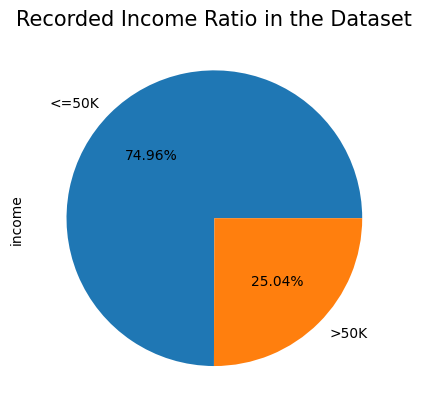

In [89]:
# Univariate Visual in the form of a Pie Chart for our target "income" feature
df['income'].value_counts().plot(kind="pie",autopct="%1.2f%%")
plt.title('Recorded Income Ratio in the Dataset', fontsize = 15)
plt.show()

Based on the pie graph above, it displays about 75% of adults in the dataset make less than 50k. Whereas, only 25% make over 50k. This tells me the dataset is unbalanced.

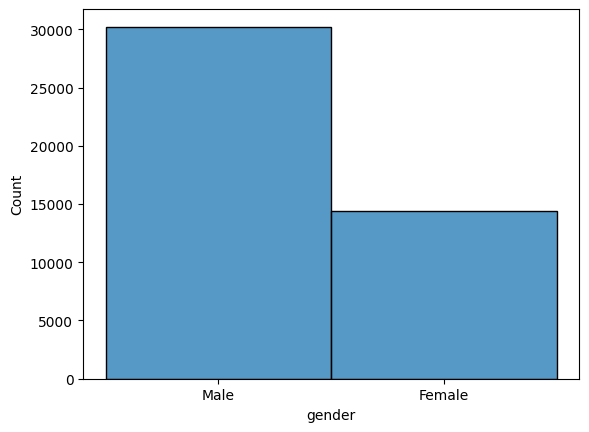

In [42]:
# Univariate Visual for 'gender' feature
sns.histplot(x='gender', data=df);

Based on the plot displayed above, the dataset contains primarily male records.

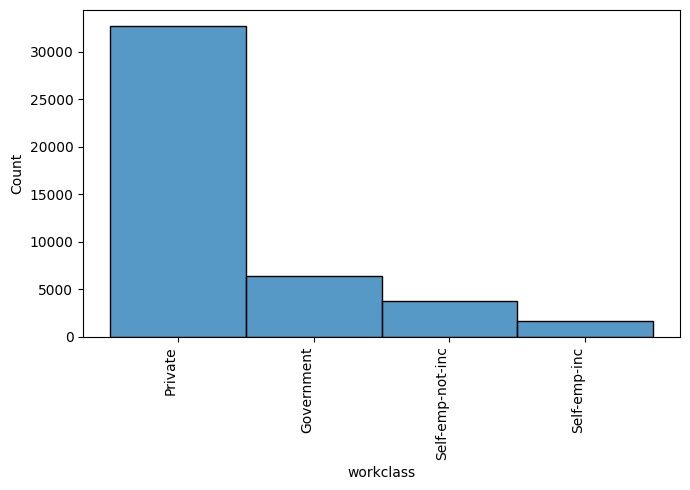

In [43]:
# Univariate Visual for 'workclass' feature

fig, ax = plt.subplots(figsize=(7,5))

sns.histplot(x='workclass', data=df);
plt.xticks(rotation=90, ha='right')
fig.tight_layout()
plt.show()

The visual above displays a high number of records for individuals in the private sector in the overall dataset.

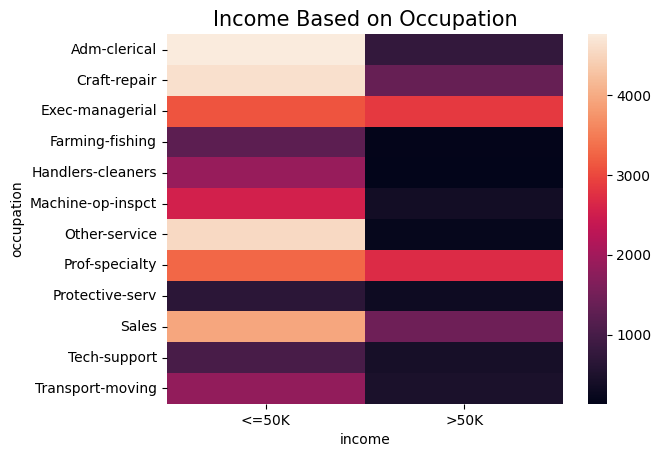

In [44]:
sns.heatmap(pd.crosstab(df['occupation'],df['income']))
plt.title('Income Based on Occupation', fontsize = 15)
plt.show()

Based on the heatmap above, their is a high rate of adults who have an executive management & professional specialty occupations making over $50k.

Compared to the majority of adults in the dataset are in the admin-clerical, craft repair, sales & other service occupations making less than $50K.

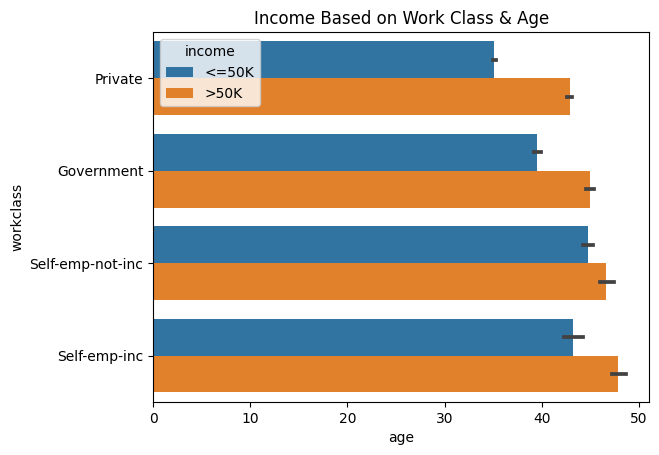

In [45]:
# Multivariate Visual in the form of a barplot for the target
# "income" with "workclass" and "age"
sns.barplot(x=df['age'],y=df['workclass'], hue=df['income'])
plt.title('Income Based on Work Class & Age', fontsize = 12)
plt.show()

- Based on the barplot above, it displays the majority of adults between the ages of 40-50 as self employed making a salary over 50K.
- Whereas, majority of young adults in the private sector
 make a salary less than 50k.

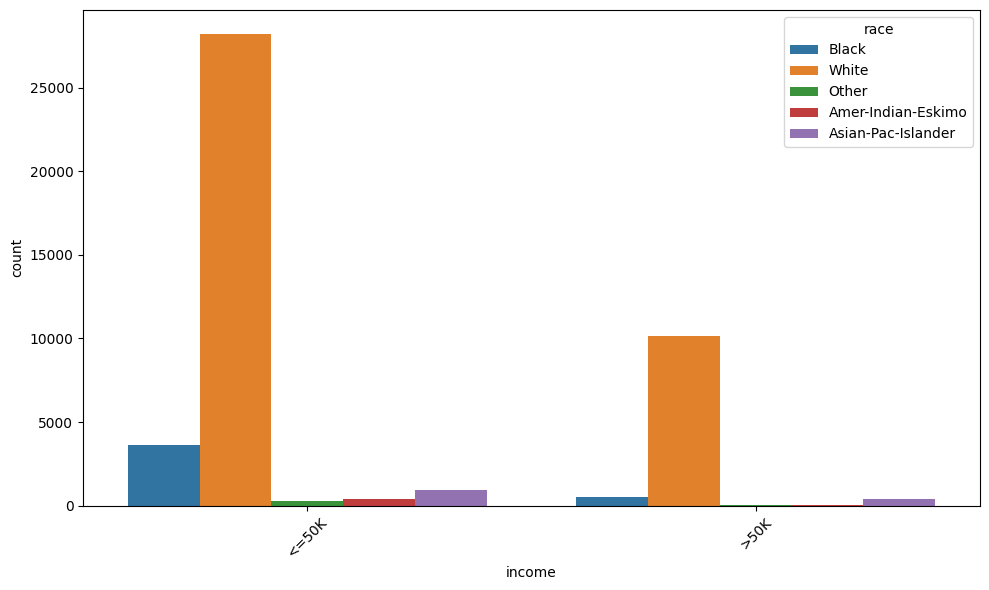

In [46]:
fig,ax = plt.subplots(figsize=(10,6))

sns.countplot(data=df, x='income',hue='race')
plt.setp(ax.get_xticklabels(), rotation = 45)

plt.tight_layout();
plt.show()

Based on the plot displayed above, there is a great disparity between income and race distinction. Notable information.

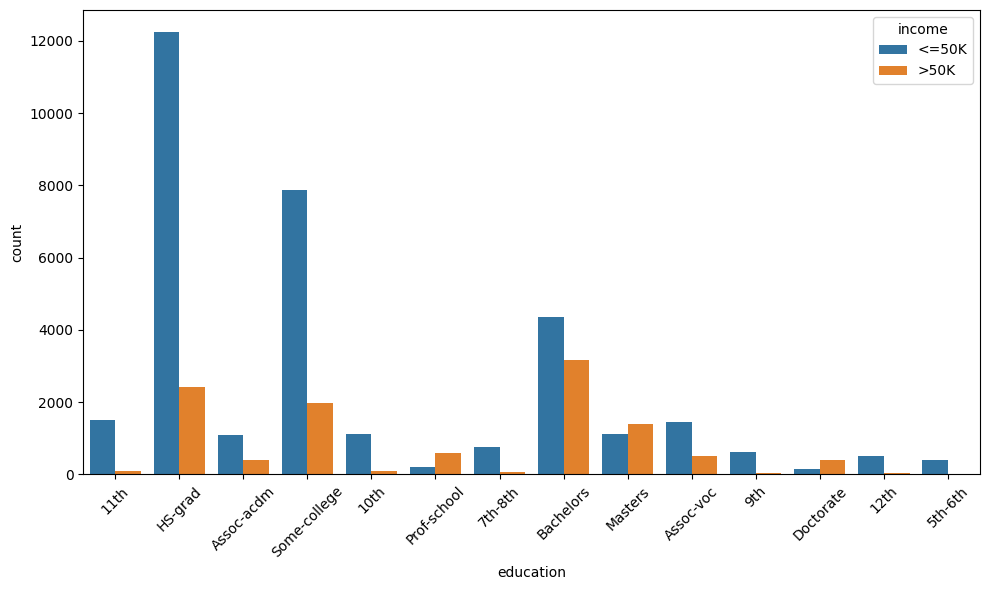

In [47]:
fig,ax = plt.subplots(figsize=(10,6))

sns.countplot(data=df, x='education',hue='income')
plt.setp(ax.get_xticklabels(), rotation = 45)

plt.tight_layout();
plt.show()

This plot shows a correlation between income as related to education. This yields some interesting trends with regard to the educational backgrounds that have an income greater than 50k.

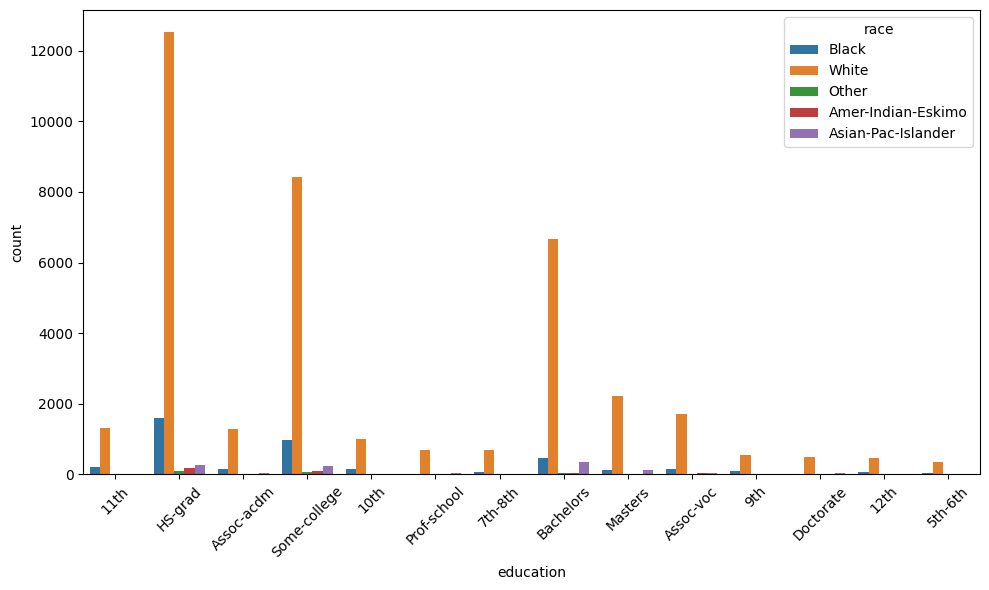

In [48]:
fig,ax = plt.subplots(figsize=(10,6))

sns.countplot(data=df, x='education', hue='race')
plt.setp(ax.get_xticklabels(), rotation = 45)

plt.tight_layout();
plt.show()

The plot above displays a strong correlation between race and higher levels of education. Major difference in educational advantage based on race that's notable.

# Preprocessing

## Train Test Split

In [49]:
# Define X and Y and complete the train test split
X = df.drop(columns="income")
y = df["income"]
y = y.replace({"<=50K":0,">50K":1})

X_train, X_test, y_train,y_test = train_test_split(X, y, random_state =42)

In [50]:
# Transformers
scaler =StandardScaler()
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# Instantiate the column selectors
num_selector = make_column_selector(dtype_include="number")
cat_selector = make_column_selector(dtype_include="object")

#Tuple
num_tuple = (scaler, num_selector)
cat_tuple = (ohe, cat_selector)

In [51]:
# Instantiate the make column transformer
preprocessor = make_column_transformer(num_tuple,
                                       cat_tuple,
                                       remainder='drop',
                                       verbose_feature_names_out=False)

In [52]:
# Scale the data
preprocessor.fit(X_train)
X_train_proc = preprocessor.transform(X_train)

# Models

## KNN Model

In [53]:
## Create an instance of the model
knn = KNeighborsClassifier()

## Create a model pipeline
knn_pipe = make_pipeline(preprocessor, knn)

## Fit the model
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5632e13c0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5633292d0>)],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

======Train Set Metrics======
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     25029
           1       0.75      0.69      0.72      8422

    accuracy                           0.86     33451
   macro avg       0.82      0.81      0.82     33451
weighted avg       0.86      0.86      0.86     33451

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      8403
           1       0.61      0.60      0.61      2748

    accuracy                           0.81     11151
   macro avg       0.74      0.74      0.74     11151
weighted avg       0.81      0.81      0.81     11151



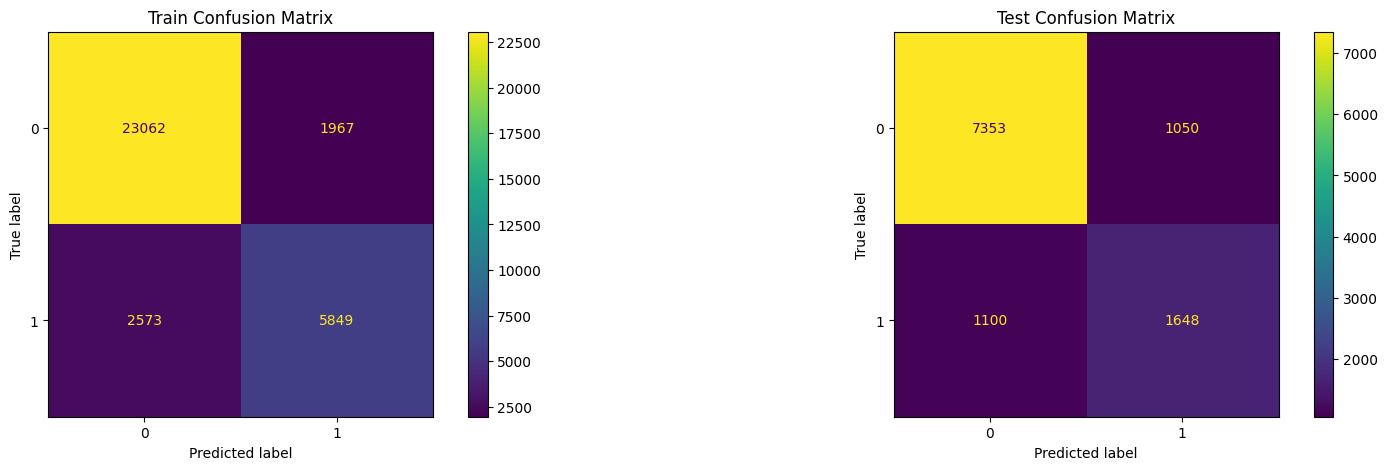

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
KNN Model,0.864279,0.694491,0.748337,0.720409,0.807192,0.599709,0.610823,0.605215


In [54]:
# Display classification report and confusion matrices
evaluate_classification(knn_pipe, X_train, y_train, X_test, y_test,
                            cmap="viridis", normalize=None, classes=None,
                            figsize=(20,5), name="KNN Model",
                            average="binary", zero_division=0)

### Tune KNN Model

In [55]:
# Define parameter dictionary
knn_params_gs = {"kneighborsclassifier__n_neighbors": list(range(1,10,2))},

In [56]:
# Implement GridSearchCV
knn_gs = GridSearchCV(knn_pipe, knn_params_gs)

In [57]:
knn_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5632e13c0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5633292d0>)],
                                                          verbose_feature_names_out=False)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid=({'kneighborsclassifier__n_neighbors': [1, 3, 5, 7,
                                                                9]},))

In [58]:
# Display best parameter
knn_gs.best_params_

{'kneighborsclassifier__n_neighbors': 9}

In [59]:
# Create a model pipeline
knn_tuned_pipe = knn_gs.best_estimator_

## Fit the model
knn_tuned_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe563e30f10>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe563e301c0>)],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=9))])

======Train Set Metrics======
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     25029
           1       0.72      0.66      0.69      8422

    accuracy                           0.85     33451
   macro avg       0.81      0.79      0.80     33451
weighted avg       0.85      0.85      0.85     33451

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      8403
           1       0.64      0.61      0.62      2748

    accuracy                           0.82     11151
   macro avg       0.76      0.75      0.75     11151
weighted avg       0.82      0.82      0.82     11151



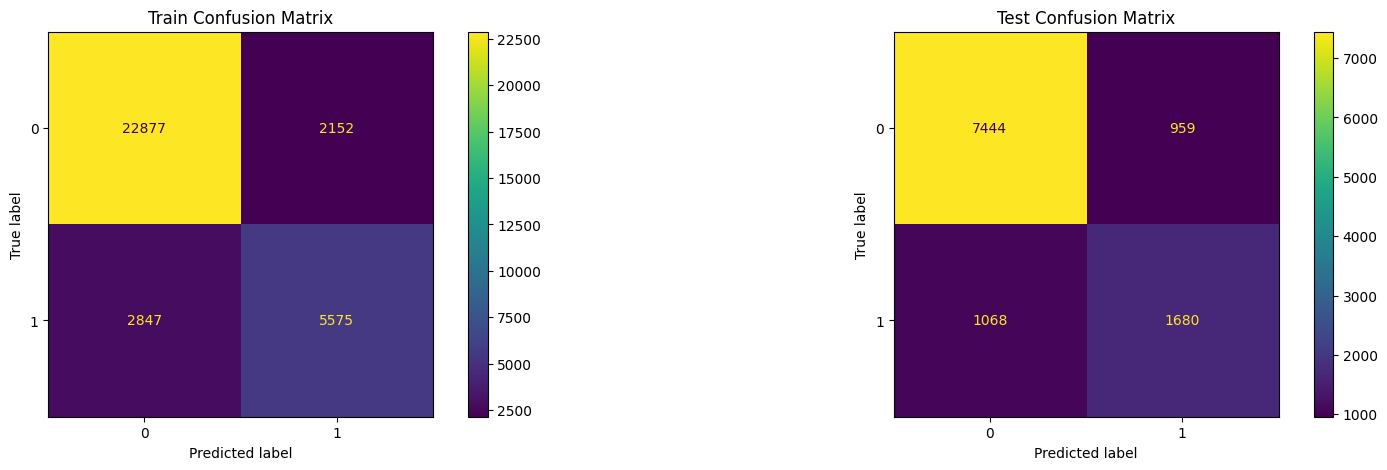

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
KNN Tuned Model,0.850558,0.661957,0.721496,0.690445,0.818223,0.611354,0.636605,0.623724


In [60]:
# Display classification report and confusion matrices
evaluate_classification(knn_tuned_pipe, X_train, y_train, X_test, y_test,
                            cmap="viridis", normalize=None, classes=None,
                            figsize=(20,5), name="KNN Tuned Model",
                            average="binary", zero_division=0)

Tuned KNN Model performing at a tested 81-82% accuracy rate compared to the base KNN Model performing between 80-81%.

## Logistic Regression Model

In [61]:
## Create an instance of the model
lreg = LogisticRegression(random_state=42)

## Create a model pipeline
lreg_pipe = make_pipeline(preprocessor, lreg)

## Fit the model
lreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5632e13c0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5633292d0>)],
                                   verbose_feature_names_out=False)),
                ('logisticregression', LogisticRegression(random_state=42))])

======Train Set Metrics======
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     25029
           1       0.70      0.55      0.62      8422

    accuracy                           0.83     33451
   macro avg       0.78      0.74      0.75     33451
weighted avg       0.82      0.83      0.82     33451

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      8403
           1       0.69      0.57      0.62      2748

    accuracy                           0.83     11151
   macro avg       0.78      0.74      0.76     11151
weighted avg       0.82      0.83      0.83     11151



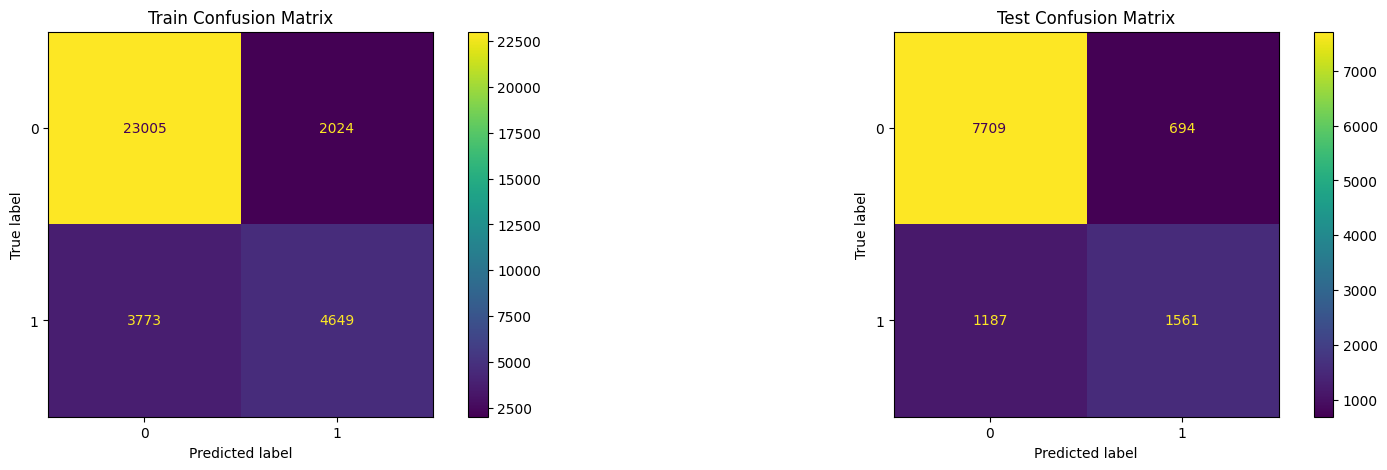

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
LREG Model,0.826702,0.552007,0.696688,0.615966,0.831316,0.568049,0.692239,0.624026


In [62]:
# Display classification report and confusion matrices
evaluate_classification(lreg_pipe, X_train, y_train, X_test, y_test,
                            cmap="viridis", normalize=None, classes=None,
                            figsize=(20,5), name="LREG Model",
                            average="binary", zero_division=0)

### Tune Logistic Regression Model

In [63]:
# List parameters
lreg_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5632e13c0>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5633292d0>)],
                     verbose_feature_names_out=False)),
  ('logisticregression', LogisticRegression(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5632e13c0>),
                                 ('onehotencoder',
                                

In [64]:
# Define parameter dictionary
lreg_params = {'logisticregression__C': [.01,.10,1.0,10.,100.],'logisticregression__penalty': ["l1","l2",None]}

In [65]:
# Implement GridSearchCV
lreg_gs = GridSearchCV(lreg_pipe, lreg_params)

In [66]:
lreg_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5632e13c0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5633292d0>)],
                                                          verbose_feature_names_out=False)),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'logisticregression__penalty': ['l1', 'l2', None]})

In [67]:
# Display best parameter
lreg_gs.best_params_

{'logisticregression__C': 1.0, 'logisticregression__penalty': 'l2'}

In [68]:
# Create a model pipeline
lreg_tuned_pipe = lreg_gs.best_estimator_

## Fit the model
lreg_tuned_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe560c87d30>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe560ce0220>)],
                                   verbose_feature_names_out=False)),
                ('logisticregression', LogisticRegression(random_state=42))])

======Train Set Metrics======
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     25029
           1       0.70      0.55      0.62      8422

    accuracy                           0.83     33451
   macro avg       0.78      0.74      0.75     33451
weighted avg       0.82      0.83      0.82     33451

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      8403
           1       0.69      0.57      0.62      2748

    accuracy                           0.83     11151
   macro avg       0.78      0.74      0.76     11151
weighted avg       0.82      0.83      0.83     11151



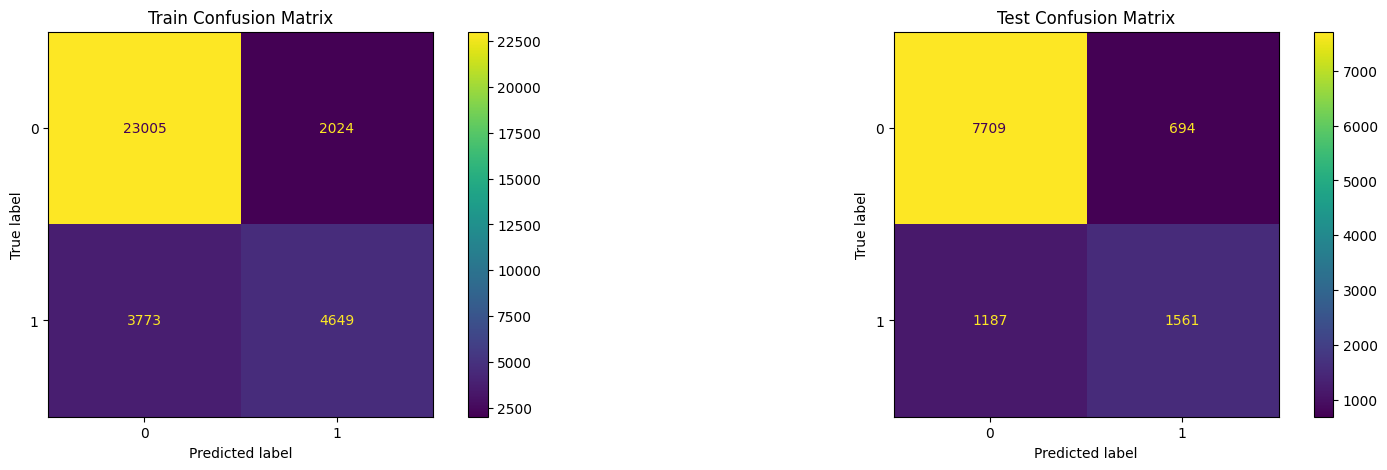

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
LREG Tuned Model,0.826702,0.552007,0.696688,0.615966,0.831316,0.568049,0.692239,0.624026


In [69]:
# Display classification report and confusion matrices
evaluate_classification(lreg_tuned_pipe, X_train, y_train, X_test, y_test,
                            cmap="viridis", normalize=None, classes=None,
                            figsize=(20,5), name="LREG Tuned Model",
                            average="binary", zero_division=0)

Tuned logistic regression model performing well at a high accuracy rate of 83%.

## Random Forest Model

In [70]:
## Create an instance of the model
rf = RandomForestClassifier(random_state=42)

## Create a model pipeline
rf_pipe = make_pipeline(preprocessor, rf)

## Fit the model
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5632e13c0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5633292d0>)],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

======Train Set Metrics======
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     25029
           1       0.93      0.91      0.92      8422

    accuracy                           0.96     33451
   macro avg       0.95      0.94      0.95     33451
weighted avg       0.96      0.96      0.96     33451

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      8403
           1       0.61      0.57      0.59      2748

    accuracy                           0.80     11151
   macro avg       0.74      0.73      0.73     11151
weighted avg       0.80      0.80      0.80     11151



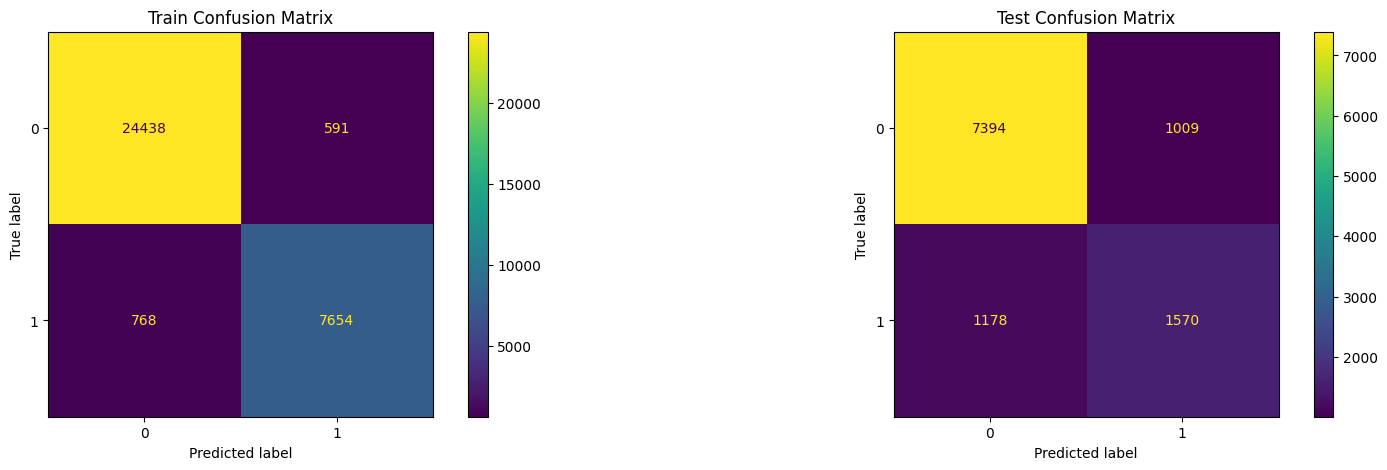

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
Random Forest Model,0.959373,0.90881,0.92832,0.918462,0.803874,0.571325,0.608763,0.58945


In [71]:
# Display classification report and confusion matrices
evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test,
                            cmap='viridis', normalize=None, classes=None,
                            figsize=(20,5), name='Random Forest Model',
                            average='binary', zero_division=0)

### Tuned Random Forest Model

In [72]:
# List parameters
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5632e13c0>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5633292d0>)],
                     verbose_feature_names_out=False)),
  ('randomforestclassifier', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5632e13c0>),
                                 ('onehotencoder',
                        

In [73]:
# Define parameter dictionary
rf_params_gs = {"randomforestclassifier__max_depth": list(range(1,10)),
                  "randomforestclassifier__n_estimators": list(range(1,25,5))}

In [74]:
# Implement GridSearchCV
rf_gs = GridSearchCV(rf_pipe, rf_params_gs)

In [75]:
rf_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5632e13c0>),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5633292d0>)],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'randomforestclassifier__max_depth': [1, 2, 3, 4, 5, 6,
                                                               7, 8, 9],
                         'randomforestclassifier__n_estimators': [1, 6, 11, 16,
                                                                  21]})

In [76]:
# Display best parameter
rf_gs.best_params_

{'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__n_estimators': 21}

In [77]:
# Create a model pipeline
rf_tuned_pipe = rf_gs.best_estimator_

## Fit the model
rf_tuned_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe566237400>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe566237e50>)],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=9, n_estimators=21,
                                        random_state=42))])

======Train Set Metrics======
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     25029
           1       0.75      0.50      0.60      8422

    accuracy                           0.83     33451
   macro avg       0.80      0.72      0.75     33451
weighted avg       0.82      0.83      0.82     33451

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      8403
           1       0.72      0.50      0.59      2748

    accuracy                           0.83     11151
   macro avg       0.78      0.72      0.74     11151
weighted avg       0.82      0.83      0.82     11151



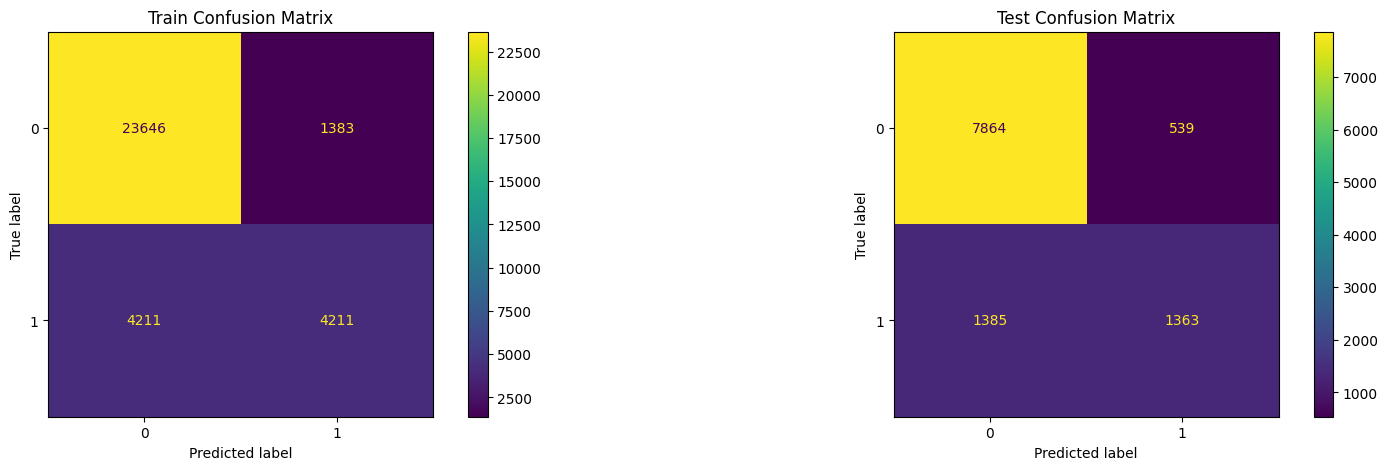

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
Random Forest Tuned Model,0.83277,0.5,0.752771,0.600885,0.827459,0.495997,0.716614,0.586237


In [78]:
# Display classification report and confusion matrices
evaluate_classification(rf_tuned_pipe, X_train, y_train, X_test, y_test,
                            cmap='viridis', normalize=None, classes=None,
                            figsize=(20,5), name='Random Forest Tuned Model',
                            average='binary', zero_division=0)

Tuned random forest model performing at a slightly lower accuracy rate but just about there with 83% compared to tuned logistic regression model.

## PCA

In [79]:
scaler = StandardScaler(with_mean=False)
preprocessor_scaler = make_pipeline(preprocessor,scaler)

In [80]:
pca = PCA(n_components=.95)
scaled_df = preprocessor_scaler.fit_transform(df)
pcs = pca.fit(scaled_df)

### Logistic Regression Model with PCA

In [81]:
## Create an instance of the model
lreg = LogisticRegression(random_state=42)
preprocessor_pca_pipe = make_pipeline(preprocessor, pca)

In [82]:
# Create a model pipeline
lreg_pca_pipe = make_pipeline(preprocessor_pca_pipe, lreg)

In [83]:
# Fit the model
lreg_pca_pipe.fit(X_train,y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('standardscaler',
                                                                   StandardScaler(),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5632e13c0>),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5633292d0>)],
                                                    verbose_feature_names_out=False)),
                                 ('pca', PCA(n_components=0.95))])),
                ('logisticregression', LogisticRegression(random_state=42))])

======Train Set Metrics======
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     25029
           1       0.69      0.54      0.60      8422

    accuracy                           0.82     33451
   macro avg       0.77      0.73      0.75     33451
weighted avg       0.81      0.82      0.81     33451

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.86      0.91      0.89      8403
           1       0.67      0.55      0.61      2748

    accuracy                           0.82     11151
   macro avg       0.77      0.73      0.75     11151
weighted avg       0.82      0.82      0.82     11151



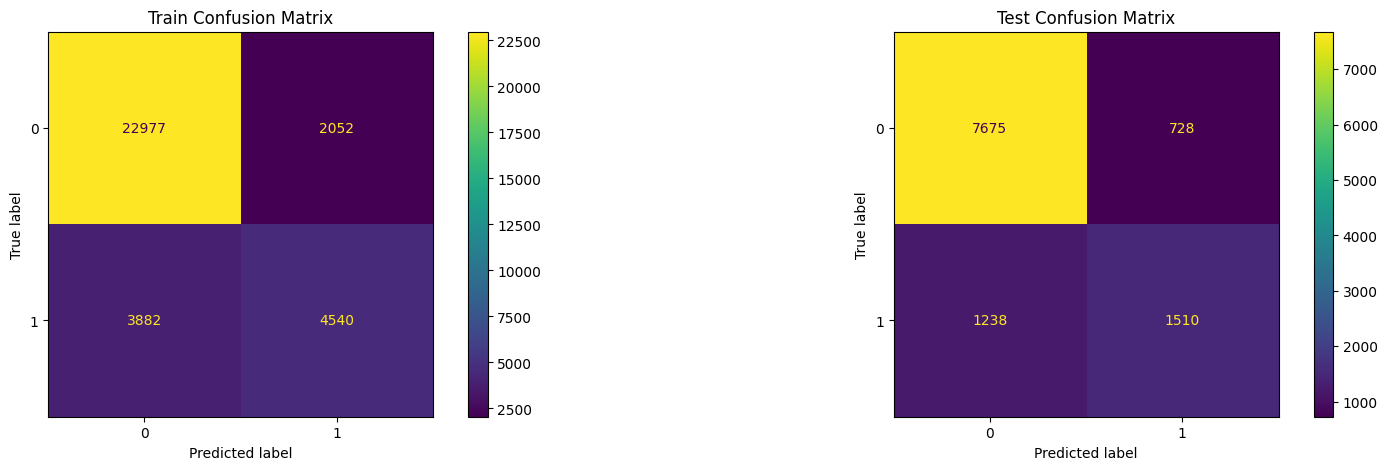

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
LREG PCA Model,0.822606,0.539064,0.688714,0.604769,0.823693,0.549491,0.67471,0.605696


In [84]:
# Display classification report and confusion matrices
evaluate_classification(lreg_pca_pipe, X_train, y_train, X_test, y_test,
                            cmap="viridis", normalize=None, classes=None,
                            figsize=(20,5), name="LREG PCA Model",
                            average="binary", zero_division=0)

The Logistic Regression Model with the PCA engineering showed a slightly lower accuracy score than the initial Tuned Logistic Regression Model. It doesnt seem to enhance the Model result in any profound way.

### Random Forest Model with PCA

In [85]:
## Create an instance of the model
rf = RandomForestClassifier()
preprocessor_pca_pipe = make_pipeline(preprocessor, pca)

In [86]:
# Create a model pipeline
rf_pca_pipe = make_pipeline(preprocessor_pca_pipe, rf)

In [87]:
# Fit the model
rf_pca_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('standardscaler',
                                                                   StandardScaler(),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5632e13c0>),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7fe5633292d0>)],
                                                    verbose_feature_names_out=False)),
                                 ('pca', PCA(n_components=0.95))])),
                ('randomforestclassifier', RandomForestClassifier())])

======Train Set Metrics======
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     25029
           1       0.93      0.91      0.92      8422

    accuracy                           0.96     33451
   macro avg       0.95      0.94      0.95     33451
weighted avg       0.96      0.96      0.96     33451

======Test Set Metrics======
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      8403
           1       0.62      0.56      0.58      2748

    accuracy                           0.81     11151
   macro avg       0.74      0.72      0.73     11151
weighted avg       0.80      0.81      0.80     11151



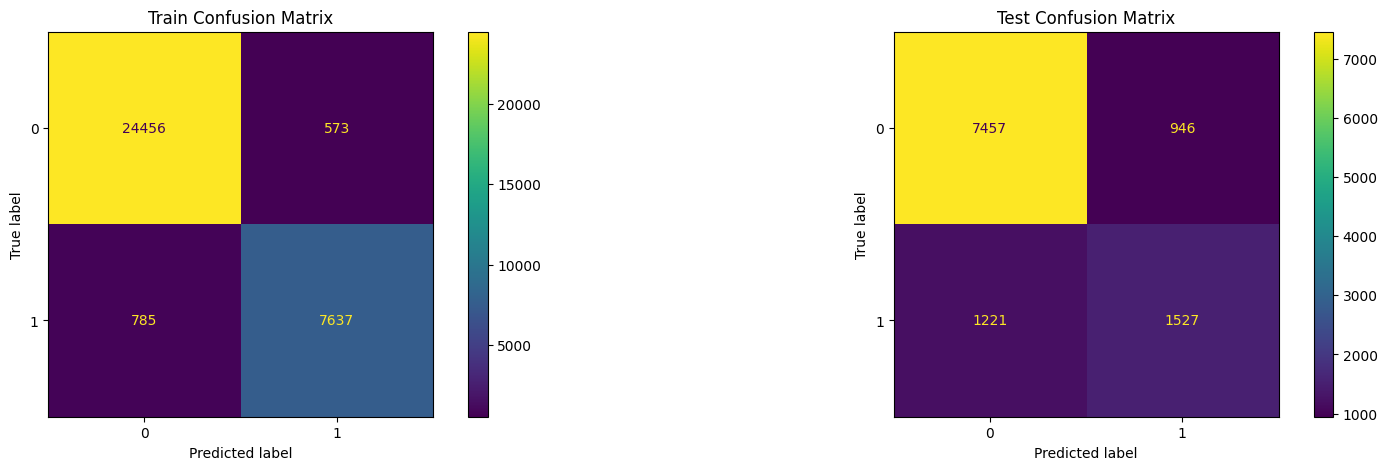

,Train Accuracy,Train Recall,Train Precision,Train F1-Score,Test Accuracy,Test Recall,Test Precision,Test F1-Score
RF PCA Model,0.959403,0.906792,0.930207,0.91835,0.805668,0.555677,0.617469,0.584945


In [88]:
# Display classification report and confusion matrices
evaluate_classification(rf_pca_pipe, X_train, y_train, X_test, y_test,
                            cmap="viridis", normalize=None, classes=None,
                            figsize=(20,5), name="RF PCA Model",
                            average="binary", zero_division=0)

This application of PCA to the Random Forest Model seemed not to yield enhanced results when examining the Test Accuracy Metric being at 80%.

Given the results of the various explored models, it's suggested that the Tuned Logistic Regression Model is the best production model for the business problem at hand. The model accuracy score being the highest at 83% implies it's the highest predictive model with the most number of samples that display out to be in the positive class. As this is a classification task of whether the income in the sample crosses a threshhold of 50k or higher, yes or no, this metric yields the most value with fewer false positives.